<font size=6em color="red"></font>



**AI/Data-Center Infrastructure vs. Water Stress in Europe (Open Data)**

Goal (short): Quantify and visualize where data-center facilities (a proxy for AI compute infrastructure) are located in Europe and how that intersects with each country’s water stress (freshwater withdrawals relative to renewable resources). We fetch everything directly via URLs in the notebook (no manual downloads).

Why this is valid for “AI’s impact on water”: AI workloads run on data centers. While public, facility-level AI water-use logs are not openly available, facility presence is a transparent proxy for where compute (and thus cooling/power water demand) concentrates. Combining facility locations with water-stress indicators highlights where AI expansion may face greater water risk. (We will state limitations clearly.)

Open data sources (queried live):

PeeringDB REST API — facility objects (“datacenters”) with coordinates and country fields; paginated JSON. We filter by country and count facilities. 
**[ Peering DB ](docs.peeringdb.com)**

World Bank Indicators API — ER.H2O.FWST.ZS “Level of water stress: freshwater withdrawal as a proportion of available freshwater resources (%)”; we fetch JSON and use the latest non-null value per country. 
**[ World Bank Open Data ](databank.worldbank.org)**

Reproducibility: No files to download; we call public APIs via requests. Plots are made with matplotlib, tables with pandas.

LLM disclosure:

LLM used: ChatGPT

Prompts:

“Build a phyton code that pulls PeeringDB facilities by country and World Bank water-stress via URLs (no manual downloads).It analyzes AI’s potential impact on water resources in Europe using only open, raw web data (no manual downloads). Use the PeeringDB REST API to retrieve data-center facilities by country (ISO-2) and the World Bank Indicators API to retrieve ER.H2O.FWST.ZS (water stress, %, ISO-3), keeping the latest non-null value per country. Join the datasets and produce: (1) a bar chart of facility counts by country, (2) a bar chart of water stress by country (latest year), and (3) a scatter plot of water stress vs facility counts. (requests, pandas, matplotlib), and ensure that my codes that I will send to you are correct. If I send you an error code, comment them with prevous codes and produce an answer accordingly."

In [5]:
# Core libraries
import requests                # HTTP calls to public APIs (PeeringDB, World Bank)
import pandas as pd            # tabular data handling
import numpy as np             # numerical helpers
import matplotlib.pyplot as plt  # plotting
import time                    # polite waits between API calls

# Plot style: make charts readable
plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False
})


**Study region and design choice**

We’ll keep the project compact by focusing on five European countries that host many data-center facilities and span different water-stress levels:

Spain (ES/ESP), Italy (IT/ITA), Greece (GR/GRC), Germany (DE/DEU), Netherlands (NL/NLD)

We’ll (1) fetch PeeringDB facility records filtered by country (ISO-2 codes), (2) fetch the World Bank water-stress indicator for those countries (ISO-3 codes), and (3) join + visualize.

**PeeringDB facilities via REST API**

We query PeeringDB’s public REST API for object type fac (facility/datacenter). The API supports filtering by fields such as country, returns JSON with a data list, and is paginated via limit and skip. We will loop pages until no more results are returned. (No API key is required for read-only access.)

In [7]:
# User-Agent header helps some CDNs; timeouts keep the notebook responsive
UA = {"User-Agent": "Mozilla/5.0 (AI-water-course-project)"}

def fetch_peeringdb_facilities(country_iso2, limit=1000, max_pages=20, pause=0.2):
    """
    Fetch all PeeringDB 'facility' objects for a given ISO-2 country code (e.g., 'DE').
    - Uses pagination via 'limit' and 'skip'
    - Returns a tidy pandas DataFrame with lat/lon + minimal metadata
    """
    base = "https://www.peeringdb.com/api/fac"
    rows = []
    skip = 0
    
    for _ in range(max_pages):
        # Build the page URL with filters and pagination
        params = {
            "country": country_iso2,  # filter facilities by country (API supports filtering by field name)
            "limit": limit,           # number of rows per page
            "skip": skip              # offset
        }
        # GET the page
        r = requests.get(base, params=params, headers=UA, timeout=30)
        r.raise_for_status()
        js = r.json()  # JSON has top-level keys 'meta' and 'data'
        data = js.get("data", [])
        if not data:
            break
        
        # Keep only the fields we need; some facilities may lack coordinates
        for d in data:
            rows.append({
                "name": d.get("name"),
                "city": d.get("city"),
                "country": d.get("country"),
                "latitude": d.get("latitude"),
                "longitude": d.get("longitude"),
            })
        # Move to next page
        skip += limit
        # short pause to be polite
        time.sleep(pause)
    
    # Build DataFrame and drop rows without coordinates
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.dropna(subset=["latitude", "longitude"]).reset_index(drop=True)
    return df


**Query PeeringDB for the five countries**

In [8]:
fac_by_country = {}
for c in EU:
    print(f"Querying PeeringDB for {c['name']}…", end=" ")
    try:
        df = fetch_peeringdb_facilities(c["iso2"])
        fac_by_country[c["iso3"]] = df
        print(f"found {len(df)} facilities with coordinates")
    except Exception as e:
        print("error:", e)
        fac_by_country[c["iso3"]] = pd.DataFrame(columns=["name","city","country","latitude","longitude"])


Querying PeeringDB for Spain… found 1643 facilities with coordinates
Querying PeeringDB for Italy… found 1740 facilities with coordinates
Querying PeeringDB for Greece… found 215 facilities with coordinates
Querying PeeringDB for Germany… found 531 facilities with coordinates
Querying PeeringDB for Netherlands… found 182 facilities with coordinates


**World Bank water-stress indicator (ER.H2O.FWST.ZS)**

We query the World Bank Indicators API for ER.H2O.FWST.ZS (“Level of water stress: freshwater withdrawal as a proportion of available freshwater resources (%)”). The indicator’s definition: the ratio of total freshwater withdrawn (all major sectors) to total renewable freshwater resources, accounting for environmental water requirements. We’ll keep the latest non-null value per country.

In [9]:
def fetch_worldbank_water_stress(iso3_list):
    """
    Fetch World Bank indicator ER.H2O.FWST.ZS for the given ISO-3 country codes.
    Returns one row per country with the latest non-null value and its year.
    """
    # Build the API URL: multiple countries separated by semicolons
    url = "https://api.worldbank.org/v2/country/" + ";".join(iso3_list) + "/indicator/ER.H2O.FWST.ZS"
    params = {"format": "json", "per_page": 20000}
    r = requests.get(url, params=params, headers=UA, timeout=30)
    r.raise_for_status()
    payload = r.json()
    
    # payload[1] holds the time-series observations
    rows = []
    for obs in (payload[1] or []):
        iso3 = obs.get("countryiso3code")
        year = obs.get("date")
        val  = obs.get("value")
        if iso3 and year is not None:
            rows.append({"iso3": iso3, "year": int(year), "water_stress_pct": val})
    
    df = pd.DataFrame(rows).sort_values(["iso3","year"], ascending=[True, False])
    latest = (df.dropna(subset=["water_stress_pct"])
                .groupby("iso3", as_index=False)
                .first())
    return latest

wb = fetch_worldbank_water_stress([c["iso3"] for c in EU])
wb


,iso3,year,water_stress_pct
0,DEU,2021,35.351657
1,ESP,2021,43.254039
2,GRC,2021,20.683795
3,ITA,2021,29.645784
4,NLD,2021,16.075663


**Build joined summary table**

We now count facilities per country from PeeringDB and join that with the latest water-stress value (and its year). This will drive our visualizations.

In [10]:
# Count facilities (with coordinates) per country
counts = []
for c in EU:
    iso3 = c["iso3"]; name = c["name"]
    n = len(fac_by_country.get(iso3, pd.DataFrame()))
    counts.append({"country": name, "iso3": iso3, "peeringdb_facilities": n})

counts_df = pd.DataFrame(counts)

# Join with World Bank water stress (%)
summary = counts_df.merge(wb, on="iso3", how="left")
summary = summary[["country","iso3","peeringdb_facilities","year","water_stress_pct"]].sort_values("country")
summary


,country,iso3,peeringdb_facilities,year,water_stress_pct
3,Germany,DEU,531,2021,35.351657
2,Greece,GRC,215,2021,20.683795
1,Italy,ITA,1740,2021,29.645784
4,Netherlands,NLD,182,2021,16.075663
0,Spain,ESP,1643,2021,43.254039


**Plot 1: Facilities per country (PeeringDB)**

This bar chart shows the count of listed facilities (a proxy for data-center presence) in each country. PeeringDB is an open, industry-maintained registry; while not a complete census, it’s a transparent lower bound for interconnection/datacenter sites.


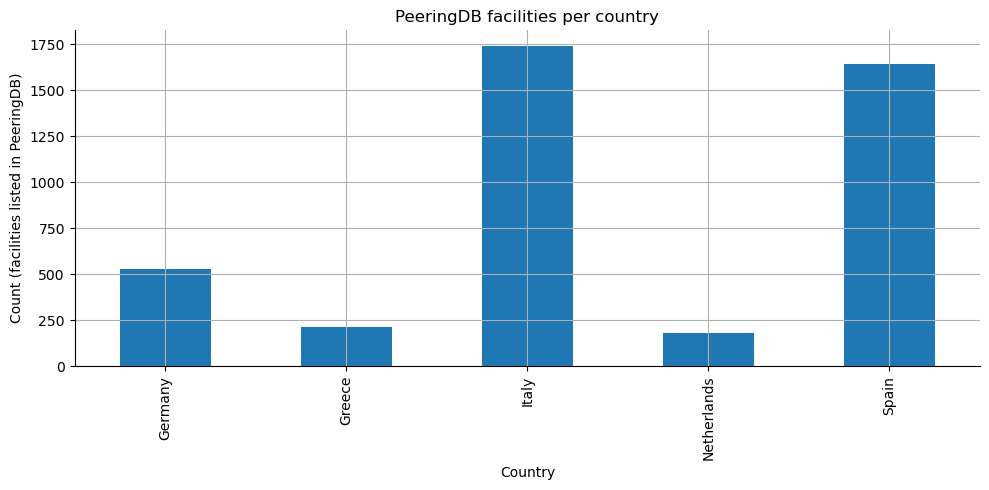

In [11]:
ax = summary.plot.bar(x="country", y="peeringdb_facilities", legend=False)
ax.set_title("PeeringDB facilities per country")
ax.set_ylabel("Count (facilities listed in PeeringDB)")
ax.set_xlabel("Country")
plt.tight_layout(); plt.show()


**Plot 2: Water stress (%) — latest available year**

This bar chart shows water stress (freshwater withdrawals as % of renewable resources). Higher % implies greater stress. We keep the latest non-null year for each country. (Indicator: ER.H2O.FWST.ZS.)

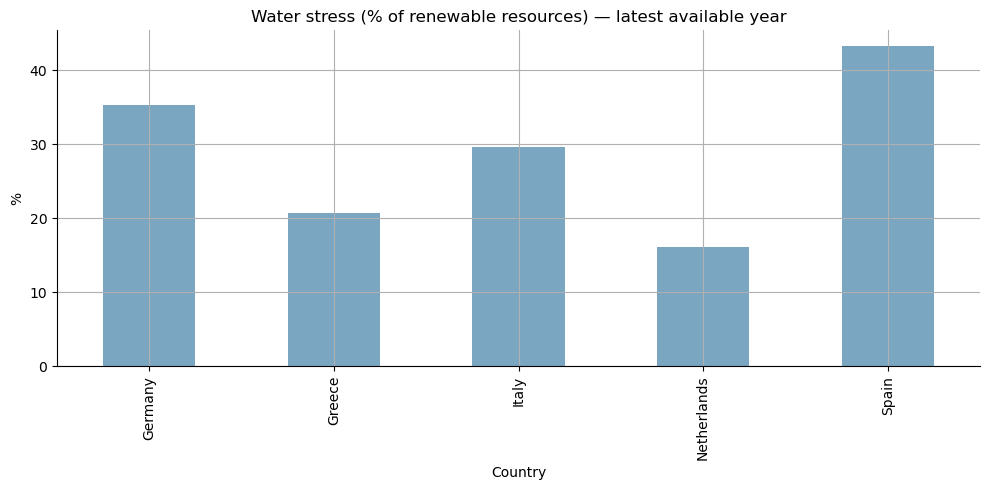

In [12]:
ax = summary.plot.bar(x="country", y="water_stress_pct", color="#7aa6c2", legend=False)
ax.set_title("Water stress (% of renewable resources) — latest available year")
ax.set_ylabel("%")
ax.set_xlabel("Country")
plt.tight_layout(); plt.show()


**Plot 3: Facilities vs. water stress (proxy risk lens)**

Finally, we create a simple scatter of water stress (%) vs facility counts.
Countries with more facilities and higher water stress may warrant extra attention for siting, cooling technologies, and grid sourcing as AI workloads grow.

Important caveats: PeeringDB coverage isn’t a census; water stress is national (local basins vary); and not every facility is “AI-only.” Still, as a public, reproducible proxy, this intersection is an instructive first look.

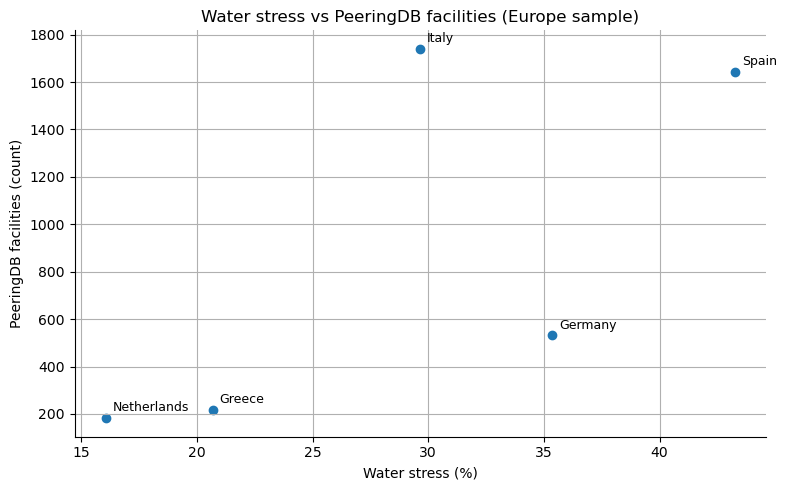

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(summary["water_stress_pct"], summary["peeringdb_facilities"])
for _, r in summary.iterrows():
    ax.annotate(r["country"], (r["water_stress_pct"], r["peeringdb_facilities"]), textcoords="offset points", xytext=(5,5), fontsize=9)
ax.set_title("Water stress vs PeeringDB facilities (Europe sample)")
ax.set_xlabel("Water stress (%)")
ax.set_ylabel("PeeringDB facilities (count)")
plt.tight_layout(); plt.show()


**Map-style scatter for one country**

Just to visualize geography, we can scatter the Netherlands facility coordinates (lon/lat).(You can switch "NLD" to any other ISO-3 code used above.)

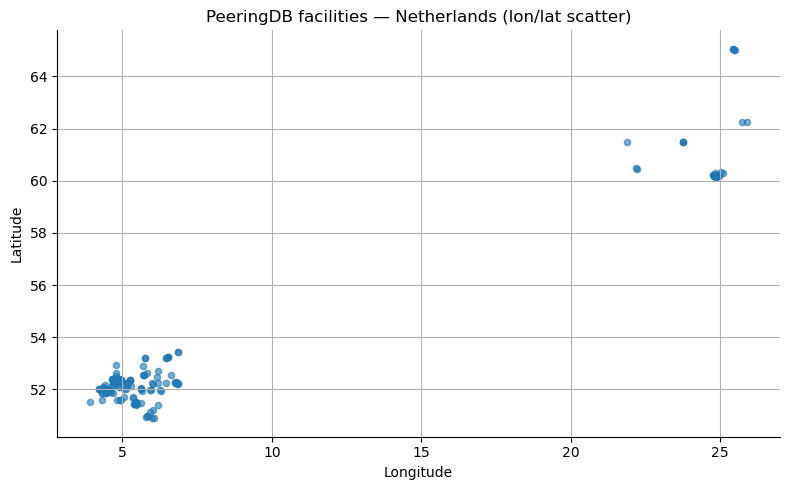

In [14]:
nl = fac_by_country.get("NLD", pd.DataFrame())
if not nl.empty:
    fig, ax = plt.subplots(figsize=(8,5))
    ax.scatter(nl["longitude"], nl["latitude"], s=20, alpha=0.6)
    ax.set_title("PeeringDB facilities — Netherlands (lon/lat scatter)")
    ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
    plt.tight_layout(); plt.show()
else:
    print("No facilities returned for the Netherlands in this run.")


**[ PeeringDB (data-center facilities) ](peeringdb.com)**
**[ World Bank (water stress indicator + API) ](https://data.worldbank.org/)**
